# Modeling spike counts

### Table of contents

1. [**Count distributions**](#likelihood)
2. [**Universal Count Model likelihood**](#UCM)
    - [True universal case ($C = K$)](#UCM_true)
    - [Approximation to the universal case ($C < K$)](#UCM_approx)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter

import matplotlib.pyplot as plt

import numpy as np
import scipy.special as sps

import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils

<a id="likelihood"></a>
## 1. Count distributions

In [2]:
def get_nll(likelihood, rate, max_count):
    neurons = likelihood.neurons
    trials = 1
    
    ### set data ###
    spikes = torch.arange(max_count)[None, :]
    likelihood.set_Y(spikes, max_count)

    ### compute NLL ###
    rates = rate*torch.ones(trials, neurons, max_count)  # rate (primary) parameter
    nll = likelihood.nll(0, rates, spikes*torch.log(rates), spikes, range(neurons))
    return nll


tbin = 0.1
max_count = 20
neurons = 1
bins = np.arange(max_count)
rate = 30.

In [3]:
likelihood = nprb.likelihoods.Poisson(tbin, neurons, 'exp')

poiss_nll = get_nll(likelihood, rate, max_count)
poiss_prbs = utils.stats.poiss_count_prob(
    bins, np.array(rate), likelihood.tbin.item())

In [4]:
alpha = 0.2*torch.ones(neurons)
likelihood = nprb.likelihoods.ZI_Poisson(tbin, neurons, 'exp', alpha)

zip_nll = get_nll(likelihood, rate, max_count)
zip_prbs = utils.stats.zip_count_prob(
    bins, np.array(rate), np.array(alpha[0].item()), likelihood.tbin.item())

In [5]:
r_inv = .1*torch.ones(neurons)
likelihood = nprb.likelihoods.Negative_binomial(tbin, neurons, 'exp', r_inv)

nb_nll = get_nll(likelihood, rate, max_count)
nb_prbs = utils.stats.nb_count_prob(
    bins, np.array(rate), np.array(r_inv[0].item()), likelihood.tbin.item())

In [6]:
log_nu = 0.2*torch.ones(neurons)
likelihood = nprb.likelihoods.COM_Poisson(tbin, neurons, 'exp', log_nu)

cmp_nll = get_nll(likelihood, rate, max_count)
cmp_prbs = utils.stats.cmp_count_prob(
    bins, np.array(rate), np.array(np.exp(log_nu[0].item())), likelihood.tbin.item())

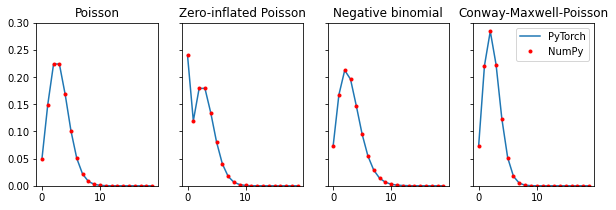

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

axes[0].plot(bins, np.exp(-poiss_nll.data.numpy()[0, :]))
axes[0].plot(bins, poiss_prbs, 'r.')
axes[0].set_ylim(0., 0.3)
axes[0].set_title('Poisson')

axes[1].plot(bins, np.exp(-zip_nll.data.numpy()[0, :]))
axes[1].plot(bins, zip_prbs, 'r.')
axes[1].set_ylim(0., 0.3)
axes[1].set_yticklabels([])
axes[1].set_title('Zero-inflated Poisson')

axes[2].plot(bins, np.exp(-nb_nll.data.numpy()[0, :]))
axes[2].plot(bins, nb_prbs, 'r.')
axes[2].set_ylim(0., 0.3)
axes[2].set_yticklabels([])
axes[2].set_title('Negative binomial')

axes[3].plot(bins, np.exp(-cmp_nll.data.numpy()[0, :]), label='PyTorch')
axes[3].plot(bins, cmp_prbs, 'r.', label='NumPy')
axes[3].set_ylim(0., 0.3)
axes[3].set_yticklabels([])
axes[3].set_title('Conway-Maxwell-Poisson')
axes[3].legend()

plt.show()

The zero-inflated Poisson (ZIP) count process

In [8]:
alpha = 0.2*torch.ones(neurons)
likelihood = nprb.likelihoods.ZI_Poisson(tbin, neurons, 'exp', alpha)

# sample
trials = 10000
rate = np.linspace(0, 100, 100)[None, None, :].repeat(trials, axis=0)
syn_train = likelihood.sample(rate, [0], XZ=None)

# empirical count mean and variance
m = syn_train.mean(0)
v = syn_train.var(0)

# theory
nx = np.linspace(0, 1.1*m.max())
var_theory = nx*(1+nx*alpha.numpy()[0])

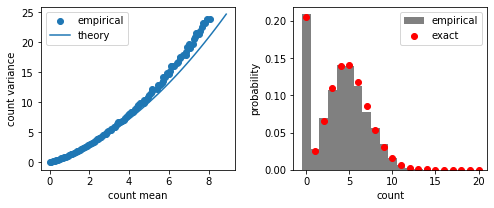

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].scatter(m, v, label='empirical')
axes[0].plot(nx, var_theory, label='theory')
axes[0].set_ylabel('count variance')
axes[0].set_xlabel('count mean')
axes[0].legend()

ind = 50

axes[1].hist(syn_train[:, 0, ind], bins=np.arange(max_count+1)-.5, density=True, 
             color='gray', label='empirical')
axes[1].set_xlabel('count')
axes[1].set_ylabel('probability')

bins = np.arange(max_count+1)
p_theory = utils.stats.zip_count_prob(
    bins, np.array(rate[0, 0, ind]), np.array(alpha[0].item()), tbin)
axes[1].scatter(np.arange(max_count+1), p_theory, c='r', label='exact')
axes[1].legend()

fig.subplots_adjust(wspace=0.3)

plt.show()

The negative binomial (NB) count process

In [10]:
r_inv = 0.2*torch.ones(neurons)
likelihood = nprb.likelihoods.Negative_binomial(tbin, neurons, 'exp', r_inv)

# sample
trials = 10000
rate = np.linspace(0, 100, 100)[None, None, :].repeat(trials, axis=0)
syn_train = likelihood.sample(rate, [0], XZ=None)

# empirical count mean and variance
m = syn_train.mean(0)
v = syn_train.var(0)

# theory
nx = np.linspace(0, 1.1*m.max())
var_theory = nx*(1+nx*r_inv.numpy()[0])

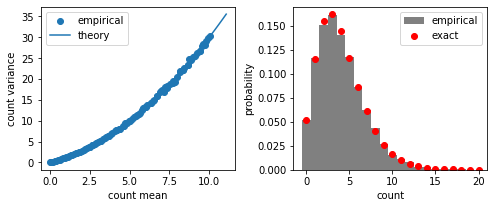

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].scatter(m, v, label='empirical')
axes[0].plot(nx, var_theory, label='theory')
axes[0].set_ylabel('count variance')
axes[0].set_xlabel('count mean')
axes[0].legend()

ind = 40

axes[1].hist(syn_train[:, 0, ind], bins=np.arange(max_count+1)-.5, density=True, 
             color='gray', label='empirical')
axes[1].set_xlabel('count')
axes[1].set_ylabel('probability')

bins = np.arange(max_count+1)
p_theory = utils.stats.nb_count_prob(
    bins, np.array(rate[0, 0, ind]), np.array(r_inv[0].item()), tbin)
axes[1].scatter(np.arange(max_count+1), p_theory, c='r', label='exact')
axes[1].legend()

fig.subplots_adjust(wspace=0.3)

plt.show()

<a id="UCM"></a>
## 2. Universal Count Model likelihood

A spike count distribution (SCD) is now modelled as a discrete distribution with support on integers $0$ to $K$, the maximum count. This is done with a softmax function, and the logits are modelled by a linear transformation of $C$ input variables or degrees of freedom $\mathbf{f} = (f_1, \ldots, f_C)$. The probability of spike count $k$ for neuron $n$ is then computed as 

$$
P(k) = \text{softmax}\left( W \cdot \phi(\mathbf{f}) + \mathbf{b} \right)_k
$$

The simplest expansion inspired by the truncated Poisson distribution is the exponential-linear expansion 

$$
\phi(\mathbf{f}) = (f_1, e^{f_1}, f_2,  e^{f_2}, \ldots)
$$

where for a particular choice of $W$ and $\mathbf{b}$ and $C=1$, $f$ can be interpreted as the logarithm of the mean count proportional to the neural firing rate.

The exponential-quadratic expansion for $\phi(\cdot)$ combines the quadratic basis expansion with an exponential mapping, i.e. for a vector $\mathbf{f} = (f_1, f_2)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_1^2, f_2^2, e^{f_1}, e^{f_2}, f_1 f_2)
$$

and for a vector $\mathbf{f} = (f_1, f_2, f_3)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, f_1^2, f_2^2, f_3^2, e^{f_1}, e^{f_2}, e^{f_3}, f_1 f_2, f_2 f_3, f_1 f_3)
$$

and so on. Note in this expansion, the degrees of freedom can mix with each other giving additional expressivity to the parameterization of SCDs.


<a id='UCM_true'></a>
### 2.1 True universal case ($C = K$)

Here, we have enough degrees of freedom $\mathbf{f}$ to fully parameterize the count distribution.

In [12]:
K = 15
C = 15

N_samps = 3

f = np.random.randn(N_samps, C)*0.1

In [13]:
phi = lambda x: x  # no basis expansion
expand_C = C


def compute_P(f, phi, W, b):
    a = (W[None, ...] @ phi(f)[..., None])[..., 0] + b
    return sps.softmax(a, axis=-1)

In [14]:
W = np.random.randn(K + 1, expand_C) * 0.0
W[:, C:] -= 1.
W[:, :C] += np.arange(K + 1)[:, None]
b = np.random.randn(K + 1) * 0.05 - sps.gammaln(np.arange(K + 1) + 1)

P = compute_P(f, phi, W, b)

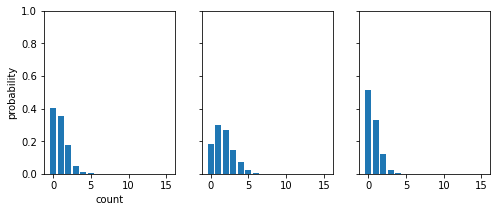

In [15]:
fig, axes = plt.subplots(1, N_samps, figsize=(8, 3))

for tr in range(N_samps):
    axes[tr].bar(np.arange(K+1), P[tr, :])
    axes[tr].set_ylim(0., 1.0)
    if tr > 0:
        axes[tr].set_yticklabels([])
    else:
        axes[tr].set_ylabel('probability')
        axes[tr].set_xlabel('count')
    
    
plt.show()

<a id='UCM_approx'></a>
### 2.2 Approximation to the universal case ($C < K$)

Here we set $W$ and $\mathbf{b}$ to almost corresponding to the Poisson case with intensity $\lambda = e^f$, introducing small random perturbations in the parameters. By increasing $C$ and using richer $\phi(\cdot)$ expansions, one can build more expressive approximations to the true universal case above.

In [16]:
K = 15
C = 1

N_samps = 3

f = np.random.randn(N_samps, C)*2.

In [17]:
def phi(f):
    # exponential-linear
    expansion = [f, np.exp(f)]
    expanded = np.concatenate(expansion, axis=-1)
    return expanded  # (samps, expand_C)

expand_C = 2 * C


def compute_P(f, phi, W, b):
    a = (W[None, ...] @ phi(f)[..., None])[..., 0] + b
    return sps.softmax(a, axis=-1)

In [18]:
W = np.random.randn(K + 1, expand_C) * 0.01
W[:, C:] -= 1.
W[:, :C] += np.arange(K + 1)[:, None]
b = np.random.randn(K + 1) * 0.01 - sps.gammaln(np.arange(K + 1) + 1)

P = compute_P(f, phi, W, b)

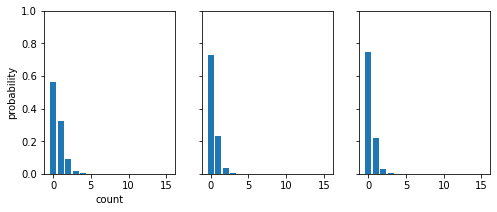

In [19]:
fig, axes = plt.subplots(1, N_samps, figsize=(8, 3))

for tr in range(N_samps):
    axes[tr].bar(np.arange(K+1), P[tr, :])
    axes[tr].set_ylim(0., 1.0)
    if tr > 0:
        axes[tr].set_yticklabels([])
    else:
        axes[tr].set_ylabel('probability')
        axes[tr].set_xlabel('count')
    
    
plt.show()